# Sommaire

PYTHON 3

>[Sommaire](#scrollTo=WYyCyOO_r6lw)

>[Imports classiques](#scrollTo=I4oNLLIcsJcg)

>[Mise en place matérielle de l'environnement](#scrollTo=mkb9LHR1r_O0)

>>[Copie des fichiers du drive vers la machine distante](#scrollTo=8CFQXIRpwsFV)

>[Chargement des données](#scrollTo=uMGcEvsOzyHe)

>[Initialisation du modèle de ML](#scrollTo=5rs8lLzQxNYJ)

>[Training](#scrollTo=6finyiXVyRIq)

>[Test du modèle](#scrollTo=X91E4eY62iJR)

>[Sauvegarde des fichiers sur le drive](#scrollTo=aVHU4uZ77k_v)



# Imports classiques

In [37]:
from google.colab import files

for file in files.os.listdir("~") :
  files.os.remove("~/"+file)
  
files.os.listdir("~")

[]

In [38]:

!pip install tqdm

from tqdm import tqdm

from keras import backend as K

K.set_image_dim_ordering('th')

# Mise en place matérielle de l'environnement

## Copie des fichiers du drive vers la machine distante

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


def uploadToDistantMachineFolder(driveFolderId,targetPath="~") :
  
  # Authentification et initialisation du client PyDrive
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Choix d'un répertoire distant pour charger les donnéelocal_download_path = os.path.expanduser('~')
  try:
    os.makedirs(targetPath)
  except: pass

  # Ciblage du dossier drive contenant les données
  folderID = driveFolderId # les données se trouvent dans mon drive à l'URL https://drive.google.com/drive/u/0/folders/<>
  file_list = drive.ListFile({'q': "'{}' in parents".format(folderID)}).GetList()

  for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(targetPath, f['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

In [40]:
uploadToDistantMachineFolder("1zjzxcb5bbGlOEs4OQSuWHWI3q_plSUEO")

title: bddBabyAI7.csv, id: 1kG9oIrHHNQXM76VU-JpzHtLCu1trc7Xo
downloading to ~/bddBabyAI7.csv
title: bddBabyAI6.csv, id: 1-LT9y-GSY-s2_qFdUlRFqMrOw70OAxLv
downloading to ~/bddBabyAI6.csv
title: bddBabyAI5.csv, id: 1Jhc0qknWcwtfheyJ_3ipzQCiSCOeAWxl
downloading to ~/bddBabyAI5.csv
title: bddBabyAI4.csv, id: 1Za9niAtJkY4UJQN5C6vj3_4SOfXhnc-q
downloading to ~/bddBabyAI4.csv
title: bddBabyAI3.csv, id: 1HcEz0FgtN8FGotQmKeZlLkYP506VXyFD
downloading to ~/bddBabyAI3.csv
title: bddBabyAI2.csv, id: 1UiPy1qzS3-BjSB1IFxXXHpVM0XgRixsg
downloading to ~/bddBabyAI2.csv
title: bddBabyAI1.csv, id: 1lKcn_oTXR3kMLZXhvODbxa920pI-1u8K
downloading to ~/bddBabyAI1.csv
title: bddBabyAI0.csv, id: 17UHvvIbMciyEY1Fm4t6tzGFqVttw6sC8
downloading to ~/bddBabyAI0.csv


Vérifier que les donnée sont bien chargées

In [41]:
from google.colab import files

files.os.listdir("~")

['bddBabyAI3.csv',
 'bddBabyAI4.csv',
 'bddBabyAI2.csv',
 'bddBabyAI1.csv',
 'bddBabyAI6.csv',
 'bddBabyAI0.csv',
 'bddBabyAI7.csv',
 'bddBabyAI5.csv']

# Chargement des données

In [0]:
import pandas as pd
import numpy as np
import math

def load_data(path) :
    data = pd.read_csv(path)
    X = data.loc[:, ["pixel"+str(i) for i in range(1024)]].values.astype('float32')
    y = data.loc[:, ["shape"]].values.astype('int32')
    arr = np.arange(X.shape[0])
    np.random.shuffle(arr)    
    
    X_train = np.zeros((X.shape[0],X.shape[1]))
    Y_train = np.zeros((X.shape[0],3))
    y_train = np.zeros((X.shape[0],1))
    
    for i in range(X.shape[0]):
      X_train[i] = X[arr[i]]
      y_train[i] = y[arr[i]]
      try:
        Y_train[i,int(y_train[i])] = 1
      except:
        print(y[i])
    X_train = X_train.reshape(X_train.shape[0],1,32,32)

    return X_train,Y_train

In [43]:
X_train_0,Y_train_0 = load_data("~/"+'bddBabyAI0.csv')
#X_train_1,Y_train_1 = load_data("~/"+"bddBabyAI1.csv")
#X_train_2,Y_train_2 = load_data("~/"+"bddBabyAI2.csv")
#X_train_3,Y_train_3 = load_data("~/"+"bddBabyAI3.csv")
#X_train_4,Y_train_4 = load_data("~/"+"bddBabyAI4.csv")
#X_train_5,Y_train_5 = load_data("~/"+"bddBabyAI5.csv")
#X_train_6,Y_train_6 = load_data("~/"+"bddBabyAI6.csv")
#X_train_7,Y_train_7 = load_data("~/"+"bddBabyAI7.csv")
X_test_all, Y_test_all = load_data("~/"+"bddBabyAIAll_test.csv")

FileNotFoundError: ignored

# Initialisation du modèle de ML

In [0]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, Adagrad
from keras import initializers

In [0]:
def classifier() :
  
  model = Sequential()
  
  model.add(Conv2D(32, (3, 3), input_shape=(1,32,32), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  
  model.add(Dense(128))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))
  
  model.add(Dense(32))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))
  
  model.add(Dense(3, activation='softmax'))
  
  return model

# Training

## Entrainement du classifieur

In [0]:
from keras.callbacks import ModelCheckpoint

def train(model, X, Y, epochs=1, batchSize=128, validation=None):
  
    batchCount = X.shape[0]//batchSize+1
    
    # Affichage des paramètres de train
    print('Epochs:',epochs)
    print('Batch size:',batchSize)
    print('Batches per epoch:',batchCount)
    
    # Programmation des sauvegardes des epochs
    filepath="weights_{epoch:02d}_{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # on entraine le réseau en enregistrant les données de train de toutes les epoch
    history = model.fit(X,Y,batch_size=batchSize,epochs=epochs,validation_data=validation,callbacks=callbacks_list,verbose=2)
    
    return history

In [0]:
model = classifier()
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

epochs_simples = 25
epochs_all = 45
batchSize = 128

history_simple = train(model,X_train_simple,Y_train_simple,epochs_simples,batchSize,(X_test_all,Y_test_all))
history_complexe = train(model,X_train_all,Y_train_all,epochs_all,batchSize,(X_test_all,Y_test_all))

Epochs: 25
Batch size: 128
Batches per epoch: 313
Train on 39996 samples, validate on 39992 samples
Epoch 1/25
 - 6s - loss: 0.4464 - acc: 0.7930 - val_loss: 0.3929 - val_acc: 0.8273

Epoch 00001: val_acc improved from -inf to 0.82726, saving model to weights_01_0.83.hdf5
Epoch 2/25
 - 5s - loss: 0.2943 - acc: 0.8824 - val_loss: 0.3107 - val_acc: 0.8664

Epoch 00002: val_acc improved from 0.82726 to 0.86641, saving model to weights_02_0.87.hdf5
Epoch 3/25
 - 5s - loss: 0.2321 - acc: 0.9079 - val_loss: 0.2546 - val_acc: 0.8991

Epoch 00003: val_acc improved from 0.86641 to 0.89911, saving model to weights_03_0.90.hdf5
Epoch 4/25
 - 5s - loss: 0.1929 - acc: 0.9247 - val_loss: 0.2238 - val_acc: 0.9121

Epoch 00004: val_acc improved from 0.89911 to 0.91207, saving model to weights_04_0.91.hdf5
Epoch 5/25
 - 5s - loss: 0.1662 - acc: 0.9343 - val_loss: 0.2112 - val_acc: 0.9112

Epoch 00005: val_acc did not improve from 0.91207
Epoch 6/25
 - 5s - loss: 0.1451 - acc: 0.9430 - val_loss: 0.1923 


Epoch 00024: val_acc improved from 0.94169 to 0.94246, saving model to weights_24_0.94.hdf5
Epoch 25/25
 - 5s - loss: 0.0494 - acc: 0.9825 - val_loss: 0.1668 - val_acc: 0.9447

Epoch 00025: val_acc improved from 0.94246 to 0.94471, saving model to weights_25_0.94.hdf5
Epochs: 45
Batch size: 128
Batches per epoch: 625
Train on 79992 samples, validate on 39992 samples
Epoch 1/45
 - 9s - loss: 0.1245 - acc: 0.9550 - val_loss: 0.0833 - val_acc: 0.9689

Epoch 00001: val_acc improved from -inf to 0.96890, saving model to weights_01_0.97.hdf5
Epoch 2/45
 - 9s - loss: 0.1065 - acc: 0.9604 - val_loss: 0.0730 - val_acc: 0.9717

Epoch 00002: val_acc improved from 0.96890 to 0.97169, saving model to weights_02_0.97.hdf5
Epoch 3/45
 - 9s - loss: 0.0958 - acc: 0.9635 - val_loss: 0.0681 - val_acc: 0.9744

Epoch 00003: val_acc improved from 0.97169 to 0.97439, saving model to weights_03_0.97.hdf5
Epoch 4/45
 - 9s - loss: 0.0895 - acc: 0.9666 - val_loss: 0.0634 - val_acc: 0.9756

Epoch 00004: val_acc 


Epoch 00022: val_acc did not improve from 0.98691
Epoch 23/45
 - 9s - loss: 0.0502 - acc: 0.9815 - val_loss: 0.0406 - val_acc: 0.9848

Epoch 00023: val_acc did not improve from 0.98691
Epoch 24/45
 - 9s - loss: 0.0491 - acc: 0.9820 - val_loss: 0.0344 - val_acc: 0.9878

Epoch 00024: val_acc improved from 0.98691 to 0.98779, saving model to weights_24_0.99.hdf5
Epoch 25/45
 - 9s - loss: 0.0484 - acc: 0.9822 - val_loss: 0.0343 - val_acc: 0.9876

Epoch 00025: val_acc did not improve from 0.98779
Epoch 26/45
 - 9s - loss: 0.0471 - acc: 0.9827 - val_loss: 0.0337 - val_acc: 0.9876

Epoch 00026: val_acc did not improve from 0.98779
Epoch 27/45
 - 9s - loss: 0.0480 - acc: 0.9824 - val_loss: 0.0332 - val_acc: 0.9878

Epoch 00027: val_acc improved from 0.98779 to 0.98785, saving model to weights_27_0.99.hdf5
Epoch 28/45
 - 9s - loss: 0.0462 - acc: 0.9831 - val_loss: 0.0325 - val_acc: 0.9881

Epoch 00028: val_acc improved from 0.98785 to 0.98808, saving model to weights_28_0.99.hdf5
Epoch 29/45
 

## Affichage des données de train

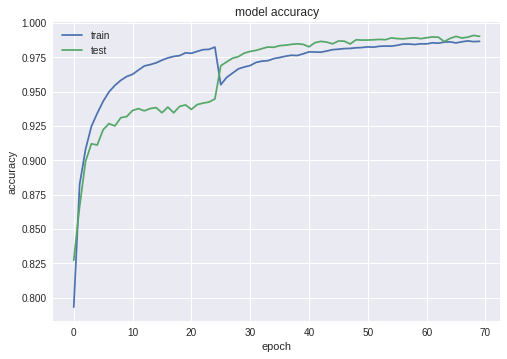

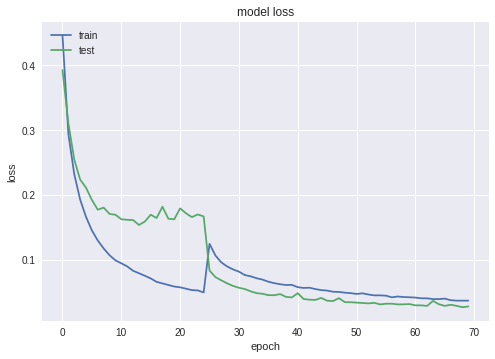

In [0]:
#print(history.history.keys())
import matplotlib.pyplot as plt
# Accuracy
plt.plot(history_simple.history['acc'][:]+history_complexe.history['acc'][:])
plt.plot(history_simple.history['val_acc'][:]+history_complexe.history['val_acc'][:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy')

# Loss
plt.plot(history_simple.history['loss'][:]+history_complexe.history['loss'][:])
plt.plot(history_simple.history['val_loss'][:]+history_complexe.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss')

## Enregistrement des données de train avec Pickle

In [0]:
import pickle
data = {'acc':history_simple.history['acc'][:]+history_complexe.history['acc'][:],
        'val_acc':history_simple.history['val_acc'][:]+history_complexe.history['val_acc'][:],
        'loss':history_simple.history['loss'][:]+history_complexe.history['loss'][:],
        'val_loss':history_simple.history['val_loss'][:]+history_complexe.history['val_loss'][:]}

with open (r"history.txt","wb") as f:
  pickle.dump(data, f)
  
  
from google.colab import files

files.download('history.txt')

# Test du modèle

In [0]:
from math import sqrt

def test(model, X, Y) :
  
  correct = 0
  
  for ID in range(X.shape[0]) :
    if np.argmax(model.predict(np.array([X[ID,:],]))) == np.argmax(Y[ID]) :
      correct += 1
      
  tau = correct/X.shape[0]
  barre = sqrt(tau*(1-tau)/X.shape[0])
  
  print("Tgen =",tau,"+-",barre)

In [0]:
test(model, X_test_all, Y_test_all)

Tgen = 0.985247049409882 +- 0.0006028724716044791


# Sauvegarde des fichiers en local

In [0]:
from google.colab import files

hdf = []

for file in files.os.listdir("/content/") :
  
    if ".hdf5" in file :
        hdf.append(file)
        #files.download("/content/"+file)
    #if ".png" in file :
    #    files.download("/content/"+file)
hdf.sort()
files.download("/content/"+hdf[-1])